##  Active and Passive Learning for Bank Notes Classification

**(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set. This is a binary classiﬁcation problem. **

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [2]:
df=pd.read_csv("data_banknote_authentication.txt",names=["varianceWTI","skewnessWTI","curtosisWTI","entropy","class"])

**(b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure**

 i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 10-fold cross validation.1 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning. 


In [11]:
train=df.sample(frac=900/df.shape[0],random_state=200)
test=df.drop(train.index)
train_bkp=train

In [12]:
print(train.shape)
test.shape

(900, 5)


(472, 5)

In [13]:
X,y=train[["varianceWTI","skewnessWTI","curtosisWTI","entropy"]], train['class']
X_test,y_test=test[["varianceWTI","skewnessWTI","curtosisWTI","entropy"]],test["class"]

*To choose parameter ranges for SVMs, One can use wide ranges for the parameters and a ﬁne grid (e.g. 1000 points) for cross validation; however,this method may be computationally expensive. An alternative way is to train the SVM with very large and very small parameters on the whole training data and ﬁnd very large and very small parameters for which the training accuracy is not below a threshold (e.g., 70%). Then one can select a ﬁxed number of parameters (e.g., 20) between those points for cross validation. For the penalty parameter, usually one has to consider increments in log(λ). For example, if one found that the accuracy of a support vector machine will not be below 70% for λ = 10−3 and λ = 106, one has to choose log(λ) ∈{−3,−2,...,4,5,6}. For the Gaussian Kernel parameter, one usually chooses linear increments,e.g. σ ∈{.1,.2,...,2}. When both σ and λ are to be chosen using cross-validation, combinations of very small and very large λ’s and σ’s that keep the accuracy above a threshold (e.g.70%) can be used to determine the ranges for σ and λ. Please note that these are very rough rules of thumb, not general procedures. *

In [18]:
passive=[]
for i in range(0,50,1):
  dfcv=pd.DataFrame(columns=["varianceWTI","skewnessWTI","curtosisWTI","entropy","class"])
  acc=[]
  train=train_bkp  
  while(train.shape[0]!=0):
    df_ToAdd=train.sample(10)
    train=train.drop(df_ToAdd.index)
    dfcv=dfcv.append(df_ToAdd)
    Xcv,ycv=dfcv[["varianceWTI","skewnessWTI","curtosisWTI","entropy"]],dfcv["class"]
    param_grid={'C': np.logspace(-2, 10, 13)};
    cv = KFold(10)
    grid_search = GridSearchCV(LinearSVC( penalty='l1', dual=False), param_grid, cv=cv,n_jobs=4)
    grid_search.fit(Xcv, ycv.astype('int'))
    acc.append(1-accuracy_score(grid_search.predict(X_test),y_test.astype('int')))
  passive.append(acc)

Added Test Errors to a list and Averaged over the 50 iterations

In [26]:
passiveAvg=[]
for i in range(0,90,1):
  sum=0
  for errlist in passive:
    sum+=errlist[i]
  passiveAvg.append(sum/50)
  

 ii. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 10-fold cross validation. Choose the 10 closest data points in the training set to the margin of the SVM2 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool.Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning. 

In [23]:
active=[]
for i in range(0,50,1):
  dfcv=pd.DataFrame(columns=["varianceWTI","skewnessWTI","curtosisWTI","entropy","class"])
  acc=[]
  train=train_bkp  
  df_ToAdd=train.sample(10)

  while(train.shape[0]!=0):
    distanceList=[]
    train=train.drop(df_ToAdd.index)
    dfcv=dfcv.append(df_ToAdd)
    Xcv,ycv=dfcv[["varianceWTI","skewnessWTI","curtosisWTI","entropy"]],dfcv["class"]
    param_grid={'C': np.logspace(-2, 10, 13)};
    cv = KFold(10)
    grid_search = GridSearchCV(LinearSVC( penalty='l1', dual=False), param_grid, cv=cv,n_jobs=8)
    grid_search.fit(Xcv, ycv.astype('int'))
    #grid_search.best_params_['C']
    acc.append(1-accuracy_score(grid_search.predict(X_test),y_test.astype('int')))
    
    for i in train.index:
      distanceList.append(abs(grid_search.decision_function(train.loc[i][:-1].values.reshape(1, -1))))
    df_ToAdd=train.iloc[sorted(range(len(distanceList)), key=lambda i: distanceList[i])[:10]]
    
    
  active.append(acc)

Added Test Errors to a list and Averaged over the 50 iterations

In [24]:
active
activeAvg=[]
for i in range(0,90,1):
  sum=0
  for errlist in active:
    sum+=errlist[i]
  activeAvg.append(sum/50)
  

**(c) Average the test errors for the incrementally trained 90 SVMs in 1(b)i and1(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same ﬁgure and report your conclusions.
**

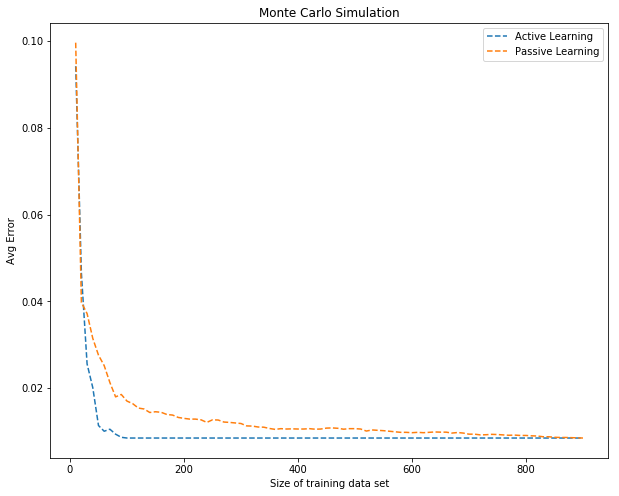

In [51]:
plt.figure(figsize=(10,8))
plt.plot(range(10,901,10),activeAvg, label='Active Learning',linestyle='dashed')
plt.plot(range(10,901,10),passiveAvg, label='Passive Learning',linestyle='dashed')
plt.xlabel('Size of training data set')
plt.ylabel('Avg Error')
plt.title("Monte Carlo Simulation")
plt.legend()
plt.show()

In [7]:
clf = LinearSVC( C=1,penalty='l1', dual=False)
clf.fit(X,y) 

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [8]:
accuracy_score(clf.predict(X_test),y_test)

0.9915254237288136

### Conclusion
**Monte Carlo Simulation** reveals that passive training samples are picked at random and may not even be support vectors, so the error rate overlaps or comes close to active learning rate initially but due to better training active learning improves faster. Both trainings gradually giving a similar result when trained long enough.